# Trolleberg data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math

### Measured (telemetry) data
From Athena

In [2]:
def applyfunc(m):
    """
    Extract values (values are always under 'v'):
    """
    
    d = json.loads(m)
    for k in d.keys():
        if isinstance(d[k], dict):
            d_sub = d[k]
            value = d_sub['v']
            
            #print(f"key: {k}, value: {value}")
            d[k] = value
    return d

In [3]:
file = "trolleberg_20250701.csv"
df_raw = pd.read_csv(file, low_memory=False)
df_raw['m'] = df_raw['m'].apply(applyfunc)
json_expanded = pd.json_normalize(df_raw['m'])

df_telem_10s = pd.concat([df_raw.drop(columns=['h','t','m','folder','dt']), json_expanded], axis=1)
df_telem_10s['DateTime'] = pd.to_datetime(df_telem_10s['loggertimestamp'], unit='s', utc=True)
df_telem_10s = df_telem_10s.drop(columns=['loggertimestamp'])
df_telem_10s = df_telem_10s.set_index('DateTime')

df_telem_10s = df_telem_10s.resample('10s').first().ffill()   # NOTE: tuning, we do not need higher resolution than 10s. Original data is 5s

#df_telem_10s = df_telem_10s.resample('10s').first().ffill()
df_telem_10s = df_telem_10s[['active_power', 'available_active']]
df_telem_10s = df_telem_10s.rename(columns={'available_active': 'available_power'})
df_telem_10s['available_power'] = df_telem_10s['available_power'].clip(0, 4550)   # NOTE: tuning, the park never produces above this value.
df_telem_10s = df_telem_10s.dropna()

del df_raw, json_expanded

df_telem_10s

,active_power,available_power
DateTime,,
2025-06-05 11:56:20+00:00,1323.77,1095.0
2025-06-05 11:56:30+00:00,1413.95,1134.0
2025-06-05 11:56:40+00:00,1538.23,1256.0
2025-06-05 11:56:50+00:00,1470.65,1304.0
2025-06-05 11:57:00+00:00,1441.74,1399.0
...,...,...
2025-07-01 08:19:40+00:00,73.15,178.0
2025-07-01 08:19:50+00:00,77.51,192.0
2025-07-01 08:20:00+00:00,80.89,192.0


### Forecast data
From databricks SQL query

In [4]:
file_forecasts = "Trolleberg_latest_wind_forecasts_2025_07_01.csv"
df_forec_15min = pd.read_csv(file_forecasts)
df_forec_15min['valid_time_cet'] = pd.to_datetime(df_forec_15min['valid_time_cet'])

df_forec_15min['valid_time_cet'] = df_forec_15min['valid_time_cet'].dt.tz_localize('Europe/Stockholm').dt.tz_convert('UTC')
df_forec_15min = df_forec_15min.rename(columns={"valid_time_cet": "valid_time_utc"})
df_forec_15min = df_forec_15min.set_index('valid_time_utc', drop=False)
df_forec_15min['predicted_power'] = 1000* df_forec_15min['total_predicted_power_mw']
df_forec_15min = df_forec_15min.drop(columns=['fetch_time_cet', 'valid_time_utc', 'predict_horizon_days_cet', 'total_predicted_power_mw'])

start = '2025-06-05 11:30:00'   # Discard forecasts before telemetery logging started
df_forec_15min = df_forec_15min[start:]

df_forec_15min

,predicted_power
valid_time_utc,
2025-06-05 11:30:00+00:00,722.0
2025-06-05 11:45:00+00:00,648.0
2025-06-05 12:00:00+00:00,592.0
2025-06-05 12:15:00+00:00,598.0
2025-06-05 12:30:00+00:00,606.0
...,...
2025-07-01 05:45:00+00:00,0.0
2025-07-01 06:00:00+00:00,0.0
2025-07-01 06:15:00+00:00,0.0


### DSO (sold and bought) data
From Kobes imbalances dashboard

In [5]:
file_dso = 'trolleberg_sold_vs_produced_20250701.csv'
df_dso_15min = pd.read_csv(file_dso)
df_dso_15min = df_dso_15min.set_index(pd.to_datetime(df_dso_15min['ts']))
df_dso_15min = df_dso_15min.tz_localize('Europe/Stockholm').tz_convert('UTC')
df_dso_15min = df_dso_15min.drop(columns=['ts'])
df_dso_15min = df_dso_15min.rename(columns={'sum(sell_vol_kwh)': 'dso_sold_energy', 'sum(production_kwh)': 'dso_produced_energy'})

df_dso_15min

,dso_sold_energy,dso_produced_energy
ts,,
2025-06-05 09:00:00+00:00,42.90,44.0
2025-06-05 09:15:00+00:00,42.90,94.0
2025-06-05 09:30:00+00:00,42.90,90.0
2025-06-05 09:45:00+00:00,42.90,103.0
2025-06-05 10:00:00+00:00,38.50,189.0
...,...,...
2025-06-30 20:45:00+00:00,51.15,118.0
2025-06-30 21:00:00+00:00,58.30,101.0
2025-06-30 21:15:00+00:00,58.30,91.0


## Create 10s power dataframe
- active_kw
- available_kw
- predicted_kw
- dso_sold_kw
- dso_produced_kw

In [6]:
df_power_10s = df_telem_10s.copy()

tmp = df_forec_15min.resample('1s').first().ffill()
df_power_10s = pd.concat([df_power_10s, tmp[['predicted_power']]], axis=1)

tmp = df_dso_15min.resample('1s').first().ffill()
tmp['dso_sold_power'] = tmp['dso_sold_energy'] * 4  # Assume constant power over 15minutes. x kWh = 4 * x kW for 15 minutes
tmp['dso_produced_power'] = tmp['dso_produced_energy'] * 4
df_power_10s = pd.concat([df_power_10s, tmp[['dso_sold_power', 'dso_produced_power']]], axis=1)

df_power_10s = df_power_10s.dropna()

del tmp
df_power_10s

,active_power,available_power,predicted_power,dso_sold_power,dso_produced_power
2025-06-05 11:56:20+00:00,1323.77,1095.0,648.0,479.6,1120.0
2025-06-05 11:56:30+00:00,1413.95,1134.0,648.0,479.6,1120.0
2025-06-05 11:56:40+00:00,1538.23,1256.0,648.0,479.6,1120.0
2025-06-05 11:56:50+00:00,1470.65,1304.0,648.0,479.6,1120.0
2025-06-05 11:57:00+00:00,1441.74,1399.0,648.0,479.6,1120.0
...,...,...,...,...,...
2025-06-30 21:44:20+00:00,280.70,329.0,144.0,233.2,336.0
2025-06-30 21:44:30+00:00,285.34,326.0,144.0,233.2,336.0
2025-06-30 21:44:40+00:00,285.68,326.0,144.0,233.2,336.0
2025-06-30 21:44:50+00:00,284.16,324.0,144.0,233.2,336.0


<Axes: title={'center': 'Trolleberg power data'}>

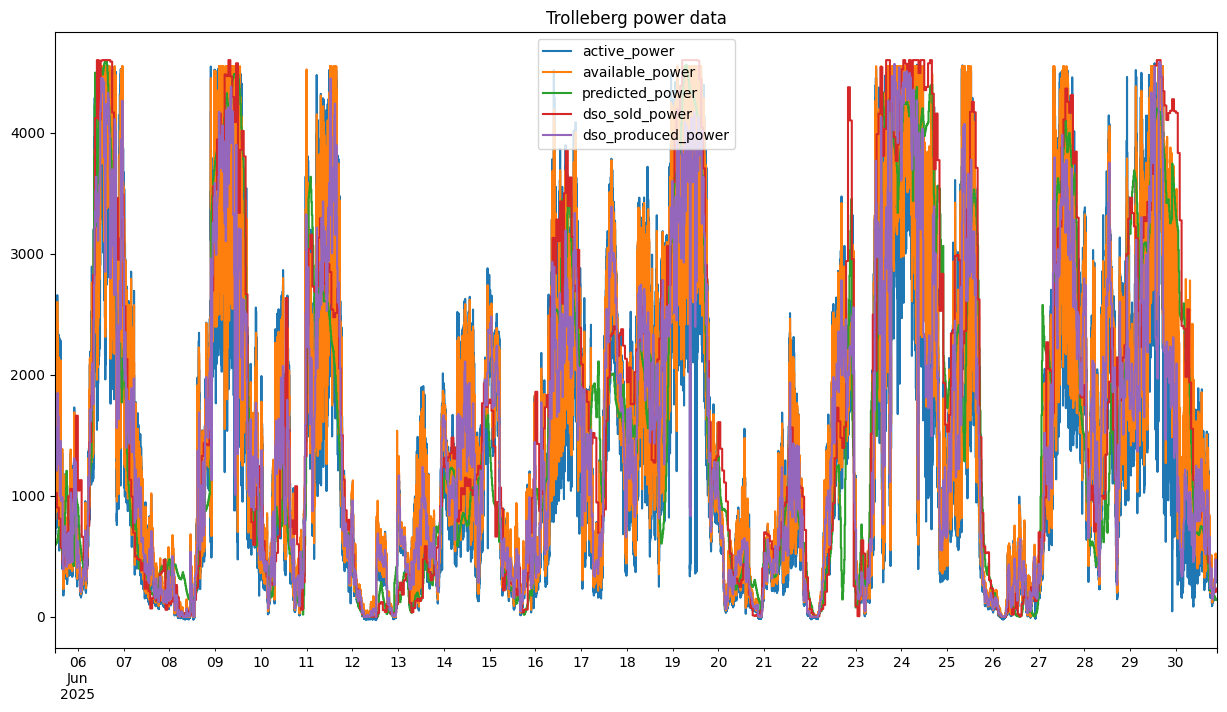

In [7]:
df_power_10s.plot(figsize=(15, 8), title='Trolleberg power data', drawstyle='steps-post')

In [8]:
np.max(df_power_10s['active_power']), np.max(df_power_10s['available_power']), np.max(df_power_10s['predicted_power']), np.max(df_power_10s['dso_sold_power']), np.max(df_power_10s['dso_produced_power'])

(np.float64(4574.6),
 np.float64(4550.0),
 np.float64(4592.0),
 np.float64(4600.0),
 np.float64(4584.0))

<Axes: >

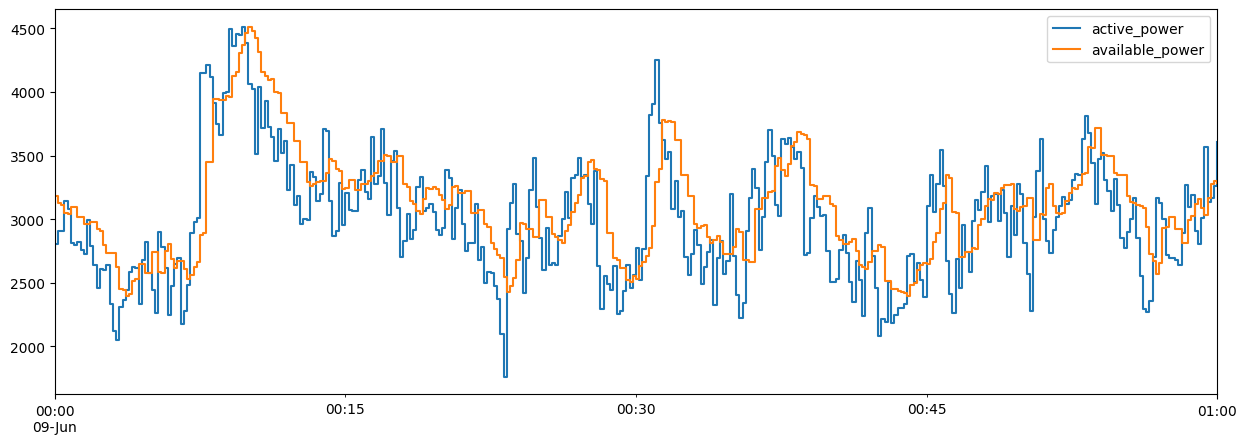

In [9]:
df_ = df_power_10s['2025-06-09 00:00:00':'2025-06-09 01:00:00']
df_[['active_power', 'available_power']].plot(figsize=(15, 5), title='', drawstyle='steps-post')

<Axes: title={'center': 'Trolleberg power data (1sec resolution)'}>

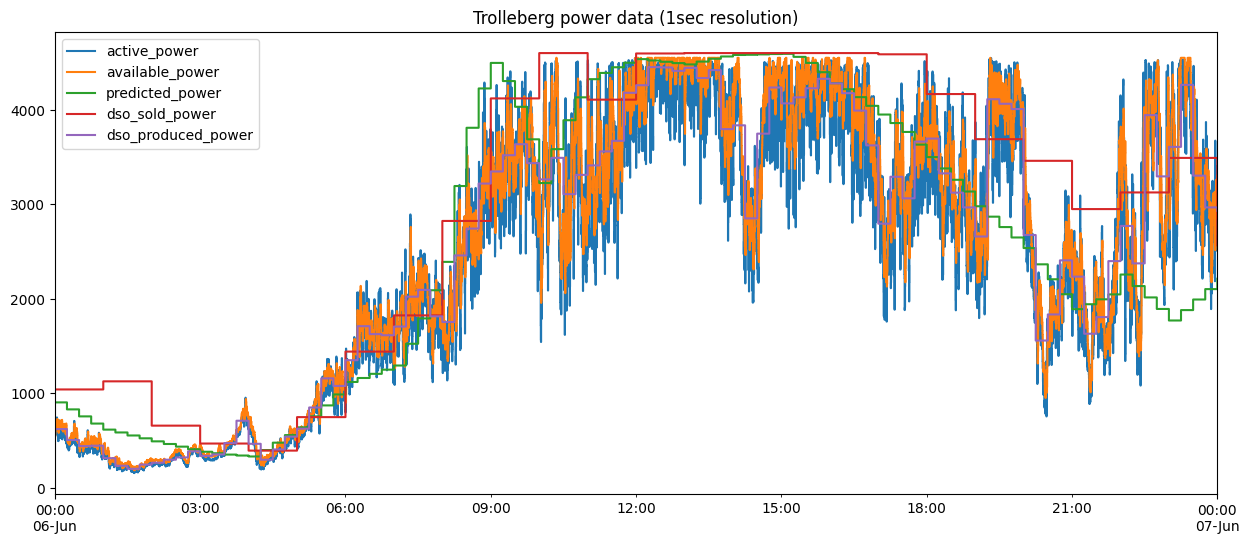

In [10]:
df_ = df_power_10s['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_.plot(figsize=(15, 6), title='Trolleberg power data (1sec resolution)', drawstyle='steps-post')

## Create 15min energy dataframe
1Hz power measurements are summed to get energy over 15 mins

In [ ]:
# Aggregate telemetry power values to 15 minutes energy values

tmp = df_telem_10s['2025-06-05 12:00:00+00:00':].copy()  # First whole 15minute after telemetry started
tmp = tmp.resample('15min').sum()
tmp['active_energy'] = tmp['active_power'] / 360  # Each sample is x/3600 kWh
tmp['available_energy'] = tmp['available_power'] / 360
df_energy_15min = tmp[['active_energy', 'available_energy']].copy()

df_energy_15min = pd.concat([df_energy_15min, df_forec_15min['predicted_power'] / 4], axis=1)
df_energy_15min = pd.concat([df_energy_15min, df_dso_15min[['dso_sold_energy', 'dso_produced_energy']]], axis=1)
df_energy_15min = df_energy_15min.dropna()

del tmp
df_energy_15min

,active_energy,available_energy,predicted_power,dso_sold_energy,dso_produced_energy
2025-06-05 12:00:00+00:00,30.096575,31.706389,148.0,255.75,315.0
2025-06-05 12:15:00+00:00,31.534069,33.102778,149.5,255.75,329.0
2025-06-05 12:30:00+00:00,31.736942,34.004167,151.5,255.75,330.0
2025-06-05 12:45:00+00:00,29.002269,30.870833,153.0,255.75,302.0
2025-06-05 13:00:00+00:00,37.400728,37.761111,154.5,225.50,392.0
...,...,...,...,...,...
2025-06-30 20:45:00+00:00,11.129986,12.169167,36.5,51.15,118.0
2025-06-30 21:00:00+00:00,9.599100,10.655278,34.5,58.30,101.0
2025-06-30 21:15:00+00:00,8.716397,9.732778,35.5,58.30,91.0
2025-06-30 21:30:00+00:00,7.977503,9.003333,36.0,58.30,84.0


<Axes: title={'center': 'Trolleberg energy data (15min resolution)'}>

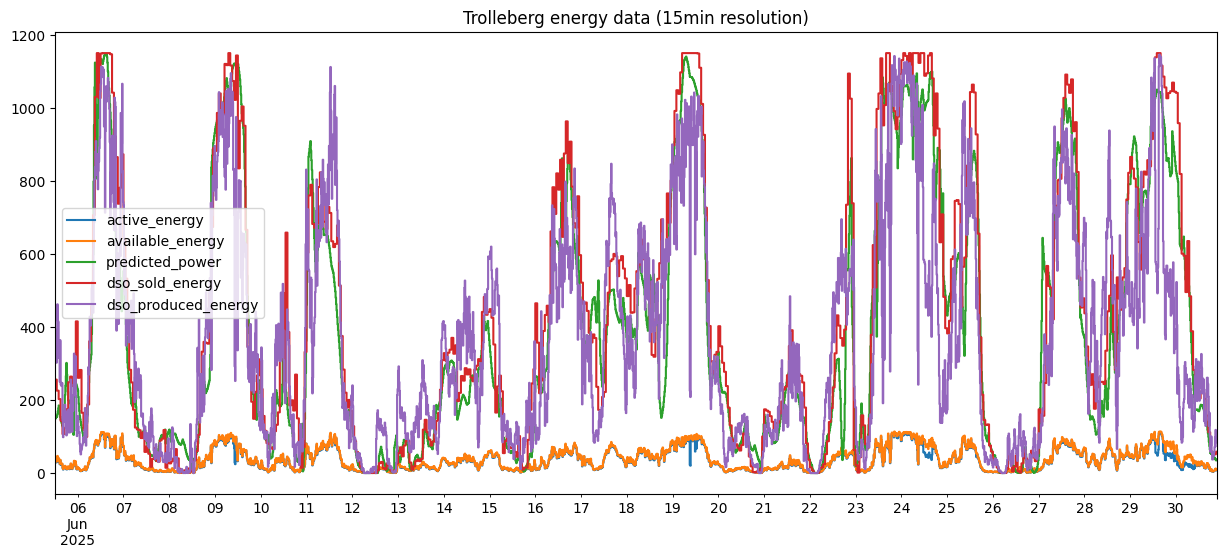

In [13]:
df_energy_15min.plot(figsize=(15, 6), title='Trolleberg energy data (15min resolution)', drawstyle='steps-post')

<Axes: title={'center': 'Trolleberg energy data (15min resolution)'}>

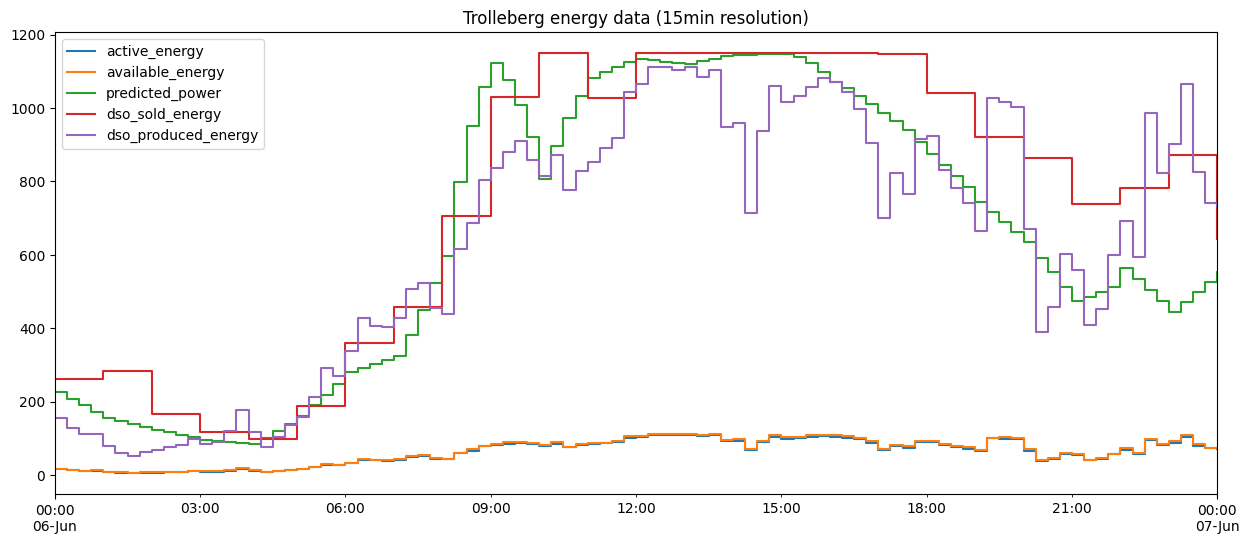

In [14]:
df_ = df_energy_15min['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_.plot(figsize=(15, 6), title='Trolleberg energy data (15min resolution)', drawstyle='steps-post')

## Get some statistics on energy error of available power

In [15]:
mean_active_energ = df_energy_15min['active_energy'].mean()
mean_available_energ = df_energy_15min['available_energy'].mean()
print(f"All data")
print(f"Mean active energy: {mean_active_energ:.2f} kWh, Mean available energy: {mean_available_energ:.2f} kWh")

All data
Mean active energy: 35.83 kWh, Mean available energy: 38.70 kWh


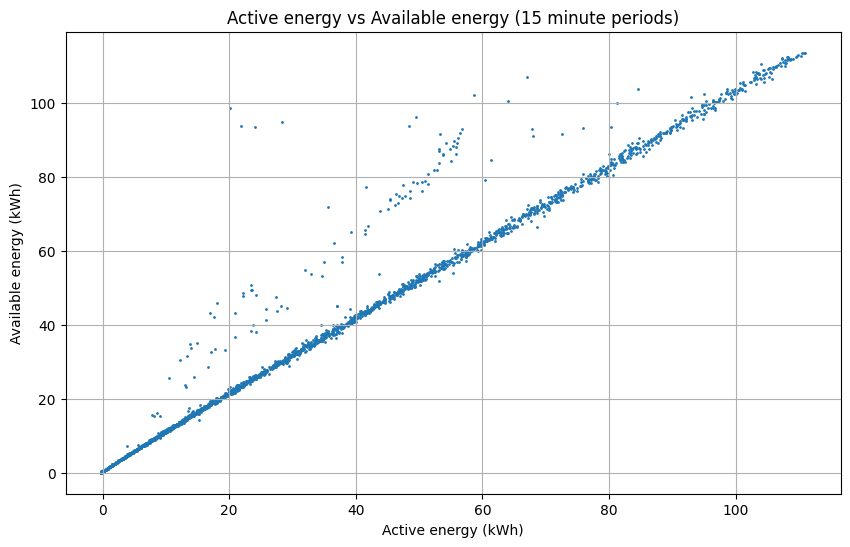

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_energy_15min['active_energy'], df_energy_15min['available_energy'], s=1)
ax.set_title('Active energy vs Available energy (15 minute periods)')
ax.set_xlabel('Active energy (kWh)')
ax.set_ylabel('Available energy (kWh)')
ax.grid()

Highest number of samples at 1.03
Mean available energy / active energy: 1.08


Text(0.5, 1.0, 'Histogram of estimated power divided by active power')

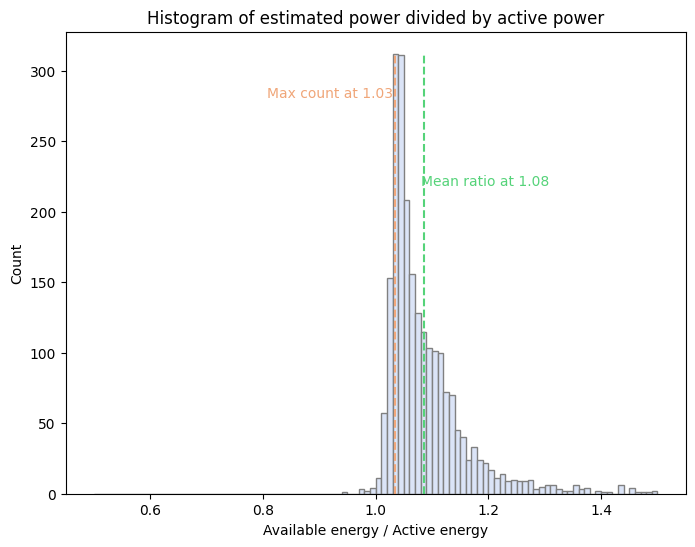

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
y,x, _ = ax.hist(df_energy_15min['available_energy']/df_energy_15min['active_energy'], bins=100, range=(0.5, 1.5), color='#DBE4F7', edgecolor='grey')
ax.set_xlabel('Available energy / Active energy')
ax.set_ylabel('Count')
print(f"Highest number of samples at {x[y.argmax()]}")
mean_ratio = df_energy_15min['available_energy'].mean() / df_energy_15min['active_energy'].mean()
print(f"Mean available energy / active energy: {mean_ratio:.2f}")
ax.vlines(x[y.argmax()]+0.005, 0, y.max(), color='#F0A679', linestyle='--', label='Max count')
ax.text(x[y.argmax()], y.max()*0.9, f'Max count at {x[y.argmax()]:.2f}', color='#F0A679', fontsize=10, ha='right')
ax.vlines(mean_ratio+0.005, 0, y.max(), color='#55D379', linestyle='--', label='Mean ratio')
ax.text(mean_ratio, y.max()*0.7, f'Mean ratio at {mean_ratio:.2f}', color='#55D379', fontsize=10, ha='left')
ax.set_title('Histogram of estimated power divided by active power')

## Create energy dataframe with 15min values forward-filled on each whole second
Use the 15 minute values but upsample so that each second has a value (the same value as the 15 minute value at the beginning of the current 15min period).

In [18]:
# why do this?
#df_energy_1s = df_energy_15min.resample('1s').ffill()
#df_energy_1s

---

# Evaluate different baseline methods

In [19]:
def print_baseline_stats(df, baseline_error_col):
    filtered_availablep_baseline_mean_error = df[baseline_error_col].mean()
    print(f"|Mean error| = {filtered_availablep_baseline_mean_error:.2f} kW     -> min mfrr power = {filtered_availablep_baseline_mean_error / 0.2:.2f} kW")

    filtered_availablep_baseline_percentile_95 = df[baseline_error_col].quantile(0.95)
    filtered_availablep_baseline_percentile_5 = df[baseline_error_col].quantile(0.05)
    result = np.abs(filtered_availablep_baseline_percentile_95 - filtered_availablep_baseline_percentile_5)/2
    print(f"|95th - 5th percentile error| / 2 = {result:.2f} kW   -> min mfrr power = {result/0.5:.2f} kW")

## Case 0: use the available p as baseline

In [20]:
mask = (df_power_10s.index < '2025-06-09 10:00:00') | (df_power_10s.index > '2025-06-09 11:00:00')    # remove mfrr testing period
df_c0 = df_power_10s[mask].copy()
df_c0['baseline'] = df_c0['available_power']
df_c0['baseline_error'] = df_c0['baseline'] - df_c0['active_power']
df_c0['baseline_error_filtered'] = df_c0['baseline_error'].rolling(5*60).mean()  # 5min rolling mean

In [21]:
print("-- All data:")
print_baseline_stats(df_c0, 'baseline_error')

threshold = 1500  # kW
df_ = df_c0[df_c0['dso_sold_power'] > threshold] # when we have predicted more than threshold kW
print(f"-- Data with DSO sold power > {threshold} kW:")
print_baseline_stats(df_, 'baseline_error')

print(f"-- With {threshold}kW threshold and 5 minute rolling mean applied:")
print_baseline_stats(df_, 'baseline_error_filtered')

-- All data:
|Mean error| = 112.10 kW     -> min mfrr power = 560.50 kW
|95th - 5th percentile error| / 2 = 474.59 kW   -> min mfrr power = 949.19 kW
-- Data with DSO sold power > 1500 kW:
|Mean error| = 182.90 kW     -> min mfrr power = 914.49 kW
|95th - 5th percentile error| / 2 = 727.75 kW   -> min mfrr power = 1455.49 kW
-- With 1500kW threshold and 5 minute rolling mean applied:
|Mean error| = 181.67 kW     -> min mfrr power = 908.34 kW
|95th - 5th percentile error| / 2 = 482.02 kW   -> min mfrr power = 964.04 kW


<Axes: title={'center': 'Case 0: Trolleberg active power vs baseline (available power, dynamic)'}>

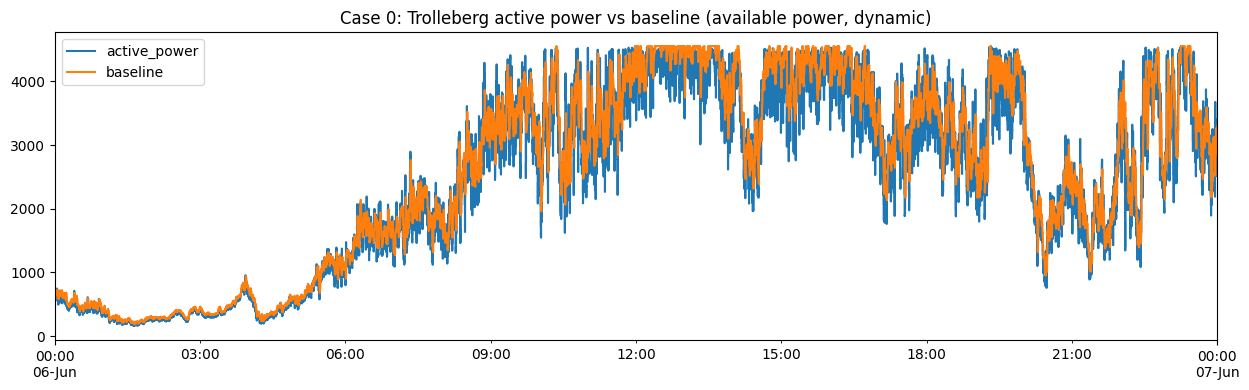

In [22]:
df_ = df_c0['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_[['active_power', 'baseline']].plot(figsize=(15,4), title='Case 0: Trolleberg active power vs baseline (available power, dynamic)', drawstyle='steps-post')

# Case 1: We use the production plan as our baseline

In [23]:
mask = (df_power_10s.index < '2025-06-09 10:00:00') | (df_power_10s.index > '2025-06-09 11:00:00')    # remove mfrr testing period
df_c1 = df_power_10s[mask].copy()
df_c1['baseline'] = df_c1['dso_sold_power']
df_c1['baseline_error'] = df_c1['baseline'] - df_c1['active_power']
df_c1['baseline_error_filtered'] = df_c1['baseline_error'].rolling(5*60).mean()  # 5min rolling mean

In [24]:
print("-- All data:")
print_baseline_stats(df_c1, 'baseline_error')

threshold = 1500  # kW
df_ = df_c1[df_c1['dso_sold_power'] > threshold] # when we have predicted more than threshold kW
print(f"-- Data with DSO sold power > {threshold} kW:")
print_baseline_stats(df_, 'baseline_error')

print(f"-- With {threshold}kW threshold and 5 minute rolling mean applied:")
print_baseline_stats(df_, 'baseline_error_filtered')

-- All data:
|Mean error| = 300.73 kW     -> min mfrr power = 1503.64 kW
|95th - 5th percentile error| / 2 = 1384.14 kW   -> min mfrr power = 2768.28 kW
-- Data with DSO sold power > 1500 kW:
|Mean error| = 721.07 kW     -> min mfrr power = 3605.36 kW
|95th - 5th percentile error| / 2 = 1579.07 kW   -> min mfrr power = 3158.14 kW
-- With 1500kW threshold and 5 minute rolling mean applied:
|Mean error| = 699.43 kW     -> min mfrr power = 3497.15 kW
|95th - 5th percentile error| / 2 = 1450.75 kW   -> min mfrr power = 2901.49 kW


<Axes: title={'center': 'Case 1: Trolleberg active power vs baseline (production plan)'}>

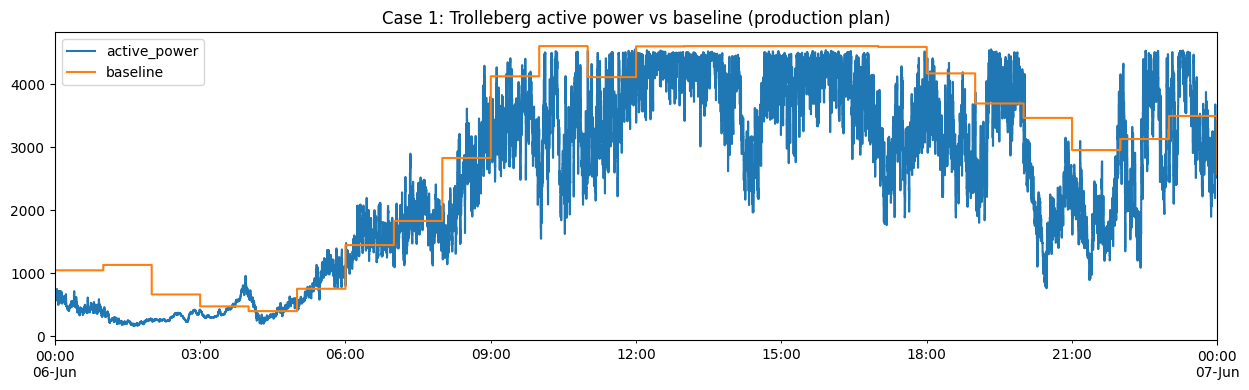

In [25]:
df_ = df_c1['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_[['active_power', 'baseline']].plot(figsize=(15,4), title='Case 1: Trolleberg active power vs baseline (production plan)', drawstyle='steps-post')

# Case 2: We do a dynamic baseline with 5 minute resolution, using a 15 minute rolling average of available power as the value

In [26]:
mask = (df_power_10s.index < '2025-06-09 10:00:00') | (df_power_10s.index > '2025-06-09 11:00:00')    # remove mfrr testing period
df_c2 = df_power_10s.loc[mask,['active_power', 'available_power', 'dso_sold_power']].copy()
movmean_minutes = 3
tmp = df_c2[['available_power']].rolling(window=int(movmean_minutes*60)).mean()
#tmp = df_c2[['available_power']].copy()
resolution_str = '15min'
tmp = tmp.resample(resolution_str).first()
tmp = tmp.resample('1s').ffill()
df_c2['baseline'] = tmp['available_power']
df_c2['baseline_error'] = df_c2['baseline'] - df_c2['active_power']
df_c2['baseline_error_filtered'] = df_c2['baseline_error'].rolling(5*60).mean()  # 5min rolling mean
df_c2 = df_c2.dropna()
del tmp
df_c2

,active_power,available_power,dso_sold_power,baseline,baseline_error,baseline_error_filtered
2025-06-05 13:04:50+00:00,1040.35,1198.0,902.0,1294.227778,253.877778,87.681011
2025-06-05 13:05:00+00:00,1100.06,1167.0,902.0,1294.227778,194.167778,88.665233
2025-06-05 13:05:10+00:00,1308.11,1178.0,902.0,1294.227778,-13.882222,88.493822
2025-06-05 13:05:20+00:00,1395.78,1159.0,902.0,1294.227778,-101.552222,88.019444
2025-06-05 13:05:30+00:00,1284.43,1253.0,902.0,1294.227778,9.797778,87.714333
...,...,...,...,...,...,...
2025-06-30 21:44:20+00:00,280.70,329.0,233.2,407.227778,126.527778,66.611889
2025-06-30 21:44:30+00:00,285.34,326.0,233.2,407.227778,121.887778,67.381426
2025-06-30 21:44:40+00:00,285.68,326.0,233.2,407.227778,121.547778,68.161463
2025-06-30 21:44:50+00:00,284.16,324.0,233.2,407.227778,123.067778,68.959033


In [27]:
print("-- All data:")
print_baseline_stats(df_c2, 'baseline_error')

threshold = 1500  # kW
df_ = df_c2[df_c2['dso_sold_power'] > threshold] # when we have predicted more than threshold kW
print(f"-- Data with DSO sold power > {threshold} kW:")
print_baseline_stats(df_, 'baseline_error')

print(f"-- With {threshold}kW threshold and 5 minute rolling mean applied:")
print_baseline_stats(df_, 'baseline_error_filtered')

-- All data:
|Mean error| = 112.72 kW     -> min mfrr power = 563.62 kW
|95th - 5th percentile error| / 2 = 839.23 kW   -> min mfrr power = 1678.45 kW
-- Data with DSO sold power > 1500 kW:
|Mean error| = 186.09 kW     -> min mfrr power = 930.44 kW
|95th - 5th percentile error| / 2 = 1104.87 kW   -> min mfrr power = 2209.73 kW
-- With 1500kW threshold and 5 minute rolling mean applied:
|Mean error| = 178.64 kW     -> min mfrr power = 893.19 kW
|95th - 5th percentile error| / 2 = 683.42 kW   -> min mfrr power = 1366.84 kW


<Axes: title={'center': 'Case 2: Trolleberg active power vs baseline (3min rolling mean of available power, 15min resolution)'}>

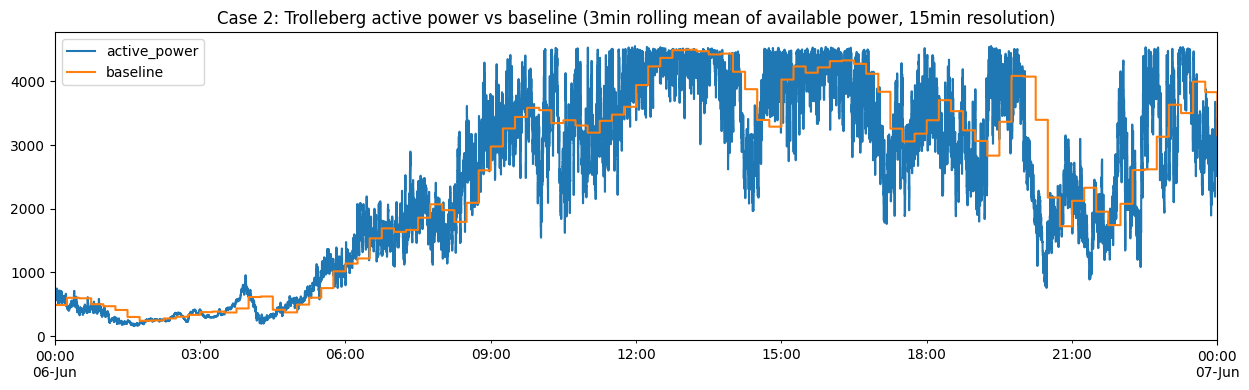

In [28]:
df_ = df_c2['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_[['active_power', 'baseline']].plot(figsize=(15,4), title=f'Case 2: Trolleberg active power vs baseline ({movmean_minutes}min rolling mean of available power, {resolution_str} resolution)', drawstyle='steps-post')

## Case 3: We do a dynamic baseline with 5 minute resolution, using a 5 minute rolling average of available power as the value

In [29]:
mask = (df_power_10s.index < '2025-06-09 10:00:00') | (df_power_10s.index > '2025-06-09 11:00:00')    # remove mfrr testing period
df_c3 = df_power_10s.loc[mask,['active_power', 'available_power', 'dso_sold_power']].copy()
tmp = df_c3[['available_power']].rolling(window=3*60, min_periods=1).mean().copy()
tmp = tmp.resample('5min').first()
tmp = tmp.resample('1s').ffill()
df_c3['baseline'] = tmp['available_power']
df_c3['baseline_error'] = df_c3['baseline'] - df_c3['active_power']
df_c3['baseline_error_filtered'] = df_c3['baseline_error'].rolling(5*60).mean()  # 5min rolling mean
df_c3 = df_c3.dropna()
del tmp
df_c3

,active_power,available_power,dso_sold_power,baseline,baseline_error,baseline_error_filtered
2025-06-05 12:46:10+00:00,874.01,1044.0,1023.0,1340.077778,466.067778,40.202149
2025-06-05 12:46:20+00:00,744.59,1023.0,1023.0,1340.077778,595.487778,42.949675
2025-06-05 12:46:30+00:00,734.20,1005.0,1023.0,1340.077778,605.877778,46.032434
2025-06-05 12:46:40+00:00,768.67,930.0,1023.0,1340.077778,571.407778,49.414560
2025-06-05 12:46:50+00:00,804.88,887.0,1023.0,1340.077778,535.197778,52.450719
...,...,...,...,...,...,...
2025-06-30 21:44:20+00:00,280.70,329.0,233.2,383.666667,102.966667,68.640667
2025-06-30 21:44:30+00:00,285.34,326.0,233.2,383.666667,98.326667,69.246907
2025-06-30 21:44:40+00:00,285.68,326.0,233.2,383.666667,97.986667,69.863648
2025-06-30 21:44:50+00:00,284.16,324.0,233.2,383.666667,99.506667,70.497922


In [30]:
print("-- All data:")
print_baseline_stats(df_c3, 'baseline_error')

threshold = 1500  # kW
df_ = df_c3[df_c3['dso_sold_power'] > threshold] # when we have predicted more than threshold kW
print(f"-- Data with DSO sold power > {threshold} kW:")
print_baseline_stats(df_, 'baseline_error')

print(f"-- With {threshold}kW threshold and 5 minute rolling mean applied:")
print_baseline_stats(df_, 'baseline_error_filtered')

-- All data:
|Mean error| = 112.61 kW     -> min mfrr power = 563.05 kW
|95th - 5th percentile error| / 2 = 798.02 kW   -> min mfrr power = 1596.04 kW
-- Data with DSO sold power > 1500 kW:
|Mean error| = 185.60 kW     -> min mfrr power = 928.00 kW
|95th - 5th percentile error| / 2 = 1058.33 kW   -> min mfrr power = 2116.67 kW
-- With 1500kW threshold and 5 minute rolling mean applied:
|Mean error| = 179.89 kW     -> min mfrr power = 899.45 kW
|95th - 5th percentile error| / 2 = 630.05 kW   -> min mfrr power = 1260.10 kW


<Axes: title={'center': 'Case 3: Trolleberg active power vs baseline (3min rolling mean of available power, 5 minute resolution)'}>

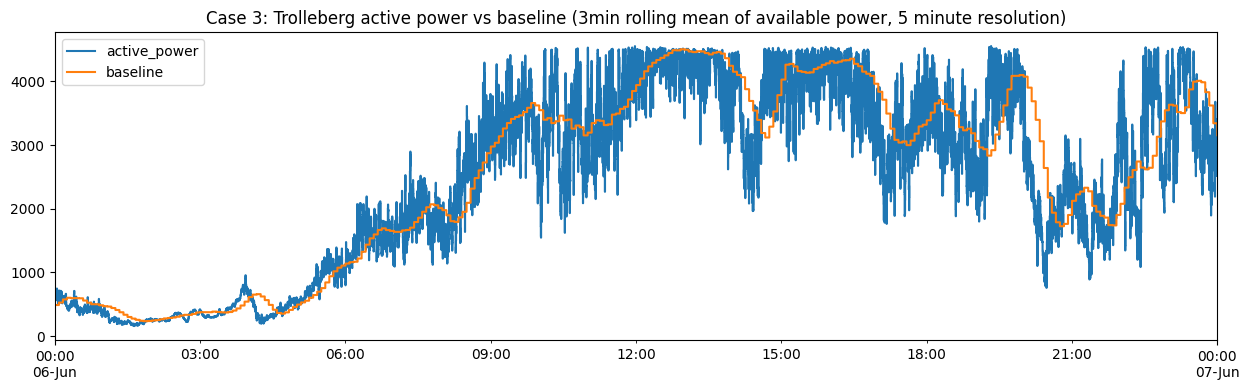

In [31]:
df_ = df_c3['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_[['active_power', 'baseline']].plot(figsize=(15,4), title='Case 3: Trolleberg active power vs baseline (3min rolling mean of available power, 5 minute resolution)', drawstyle='steps-post')

## Case 4: Predict next baseline by taking the slope between current and previous 5 minute interval

In [32]:
mask = (df_power_10s.index < '2025-06-09 10:00:00') | (df_power_10s.index > '2025-06-09 11:00:00')    # remove mfrr testing period
df_c4 = df_power_10s.loc[mask,['active_power', 'available_power', 'dso_sold_power']].copy()
tmp = df_c4[['available_power']].rolling(window=5*60, min_periods=1).mean()
tmp = tmp.resample('5min').first()

# Estimate baseline as current 5 minute value + half of the difference to the previous 5 minute value
tmp['baseline'] = 0
prev = None
#for index, row in tmp.iterrows():
for i in range(len(tmp)):
    val = tmp['available_power'].iloc[i]
    if prev is None:
        prev = val
        tmp['baseline'].iloc[i] = val
        continue
    
    estimate = np.min([val + (val - prev) / 2, 4550])  # Limit to max 4550 kW
    tmp['baseline'].iloc[i] = estimate
    prev = val

tmp = tmp.resample('1s').ffill()
df_c4['baseline'] = tmp['baseline']
    
df_c4['baseline_error'] = df_c4['baseline'] - df_c4['active_power']
df_c4['baseline_error_filtered'] = df_c4['baseline_error'].rolling(5*60).mean()  # 5min rolling mean
df_c4 = df_c4.dropna()
del tmp

/var/folders/ht/gf_rn2350rldpdtcvp3948c40000gn/T/ipykernel_77012/1451894946.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tmp['baseline'].iloc[i] = val
/var/folders/ht/gf_rn2350rldpdtcvp3948c40000gn/T/ipykernel_77012/1451894946.py:14:

<Axes: title={'center': 'Case 4: Trolleberg active power vs baseline (estimated based on slope)'}>

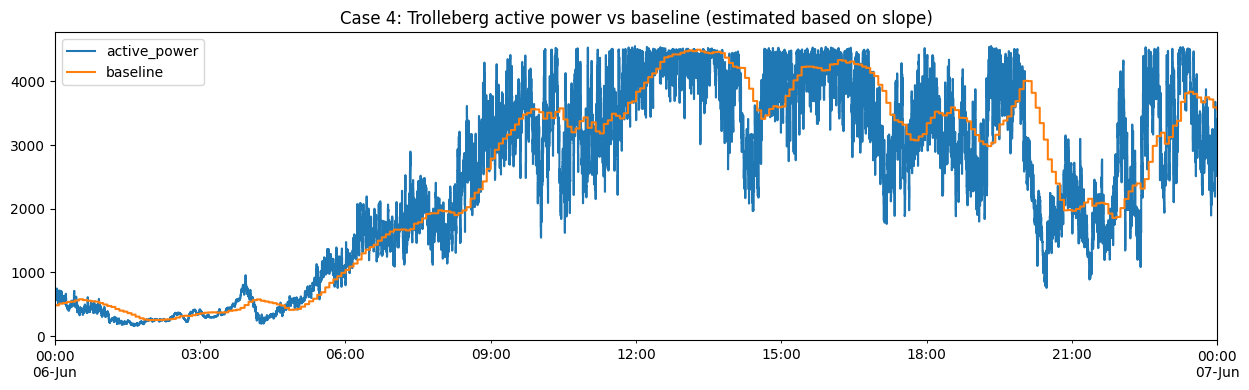

In [33]:
df_ = df_c4['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_[['active_power', 'baseline']].plot(figsize=(15,4), title='Case 4: Trolleberg active power vs baseline (estimated based on slope)', drawstyle='steps-post')

In [34]:
print("-- All data:")
print_baseline_stats(df_c4, 'baseline_error')

threshold = 1500  # kW
df_ = df_c4[df_c4['dso_sold_power'] > threshold] # when we have predicted more than threshold kW
print(f"-- Data with DSO sold power > {threshold} kW:")
print_baseline_stats(df_, 'baseline_error')

print(f"-- With {threshold}kW threshold and 5 minute rolling mean applied:")
print_baseline_stats(df_, 'baseline_error_filtered')

-- All data:
|Mean error| = 111.54 kW     -> min mfrr power = 557.68 kW
|95th - 5th percentile error| / 2 = 812.56 kW   -> min mfrr power = 1625.13 kW
-- Data with DSO sold power > 1500 kW:
|Mean error| = 182.83 kW     -> min mfrr power = 914.15 kW
|95th - 5th percentile error| / 2 = 1076.05 kW   -> min mfrr power = 2152.09 kW
-- With 1500kW threshold and 5 minute rolling mean applied:
|Mean error| = 175.49 kW     -> min mfrr power = 877.45 kW
|95th - 5th percentile error| / 2 = 697.63 kW   -> min mfrr power = 1395.25 kW


# Case 5: Semi-dynamic baseline with 3.5 minute resolution, using the latest available power

In [35]:
mask = (df_power_10s.index < '2025-06-09 10:00:00') | (df_power_10s.index > '2025-06-09 11:00:00')    # remove mfrr testing period
df_c5 = df_power_10s.loc[mask,['active_power', 'available_power', 'dso_sold_power']].copy()
movmean_minutes = 2
#tmp = df_c5[['available_power']].rolling(window=movmean_minutes*60, min_periods=1).mean().copy() - 114
tmp = df_c5[['available_power']].copy() - 120
tmp = tmp.resample('3.5min').first()
tmp = tmp.resample('1s').ffill()
df_c5['baseline'] = tmp['available_power']
df_c5['baseline_error'] = df_c5['baseline'] - df_c5['active_power']
df_c5['baseline_error_filtered'] = df_c5['baseline_error'].rolling(5*60).mean()  # 5min rolling mean
df_c5 = df_c5.dropna()
del tmp
df_c5

,active_power,available_power,dso_sold_power,baseline,baseline_error,baseline_error_filtered
2025-06-05 12:46:10+00:00,874.01,1044.0,1023.0,1300.0,425.99,-78.118233
2025-06-05 12:46:20+00:00,744.59,1023.0,1023.0,1300.0,555.41,-75.104300
2025-06-05 12:46:30+00:00,734.20,1005.0,1023.0,885.0,150.80,-73.138467
2025-06-05 12:46:40+00:00,768.67,930.0,1023.0,885.0,116.33,-70.873267
2025-06-05 12:46:50+00:00,804.88,887.0,1023.0,885.0,80.12,-68.954033
...,...,...,...,...,...,...
2025-06-30 21:42:20+00:00,312.15,354.0,233.2,246.0,-66.15,-72.961600
2025-06-30 21:42:30+00:00,313.34,352.0,233.2,246.0,-67.34,-72.901667
2025-06-30 21:42:40+00:00,310.60,352.0,233.2,246.0,-64.60,-72.831000
2025-06-30 21:42:50+00:00,308.14,353.0,233.2,246.0,-62.14,-72.761900


<Axes: title={'center': 'Case 5: Trolleberg active power vs baseline (3.5min resolution, latest value)'}>

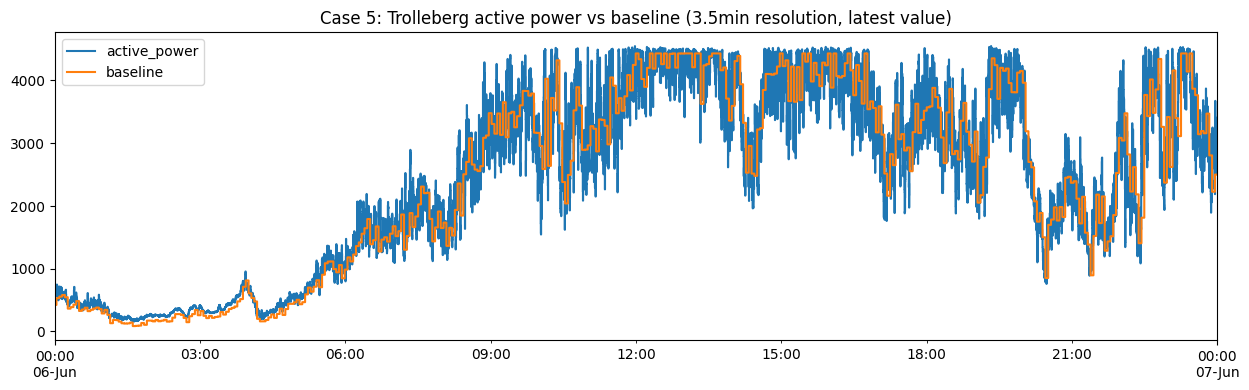

In [36]:
df_ = df_c5['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_[['active_power', 'baseline']].plot(figsize=(15,4), title='Case 5: Trolleberg active power vs baseline (3.5min resolution, latest value)', drawstyle='steps-post')

In [37]:
print("-- All data:")
print_baseline_stats(df_c5, 'baseline_error')

threshold = 1500  # kW
df_ = df_c5[df_c5['dso_sold_power'] > threshold] # when we have predicted more than threshold kW
print(f"-- Data with DSO sold power > {threshold} kW:")
print_baseline_stats(df_, 'baseline_error')

print(f"-- With {threshold}kW threshold and 5 minute rolling mean applied:")
print_baseline_stats(df_, 'baseline_error_filtered')

-- All data:
|Mean error| = -7.46 kW     -> min mfrr power = -37.32 kW
|95th - 5th percentile error| / 2 = 695.96 kW   -> min mfrr power = 1391.92 kW
-- Data with DSO sold power > 1500 kW:
|Mean error| = 64.04 kW     -> min mfrr power = 320.19 kW
|95th - 5th percentile error| / 2 = 982.32 kW   -> min mfrr power = 1964.65 kW
-- With 1500kW threshold and 5 minute rolling mean applied:
|Mean error| = 62.46 kW     -> min mfrr power = 312.30 kW
|95th - 5th percentile error| / 2 = 510.69 kW   -> min mfrr power = 1021.37 kW


In [38]:
threshold = 2000
print(f"Baseline error statistics for baseline above {threshold} kW:")

# Calculate the mean change in setpoint.
tmp = df_c5[df_c5['baseline'] > threshold].copy()  # Only consider values above 2000 kW
tmp = tmp.resample('3.5min').first()
mean_diff = tmp['baseline'].diff().mean()
print(f"Mean change in setpoint: {mean_diff:.2f} kW")

# ----

# 1st percentile of the change in setpoint
percentile_1_diff = tmp['baseline'].diff().quantile(0.01)
print(f"1st percentile change in setpoint: {percentile_1_diff:.2f} kW")

# 5th percentile of the change in setpoint
percentile_5_diff = tmp['baseline'].diff().quantile(0.05)
print(f"5th percentile change in setpoint: {percentile_5_diff:.2f} kW") 

# 10th percentile of the change in setpoint
percentile_10_diff = tmp['baseline'].diff().quantile(0.10)
print(f"10th percentile change in setpoint: {percentile_10_diff:.2f} kW")

# 25th percentile of the change in setpoint
percentile_25_diff = tmp['baseline'].diff().quantile(0.25)
print(f"25th percentile change in setpoint: {percentile_25_diff:.2f} kW")

# 35th percentile of the change in setpoint
percentile_35_diff = tmp['baseline'].diff().quantile(0.35)
print(f"35th percentile change in setpoint: {percentile_35_diff:.2f} kW")

# -----

# 50th percentile of the change in setpoint
median_diff = tmp['baseline'].diff().median()
print(f"Median change in setpoint: {median_diff:.2f} kW")

# -----

# 65th percentile of the change in setpoint
percentile_65_diff = tmp['baseline'].diff().quantile(0.65)
print(f"65th percentile change in setpoint: {percentile_65_diff:.2f} kW")

# 75th percentile of the change in setpoint
percentile_75_diff = tmp['baseline'].diff().quantile(0.75)
print(f"75th percentile change in setpoint: {percentile_75_diff:.2f} kW")

# 90th percentile of the change in setpoint
percentile_90_diff = tmp['baseline'].diff().quantile(0.90)
print(f"90th percentile change in setpoint: {percentile_90_diff:.2f} kW")

# 95th percentile of the change in setpoint
percentile_95_diff = tmp['baseline'].diff().quantile(0.95)
print(f"95th percentile change in setpoint: {percentile_95_diff:.2f} kW")

# 99th percentile of the change in setpoint
percentile_99_diff = tmp['baseline'].diff().quantile(0.99)
print(f"99th percentile change in setpoint: {percentile_99_diff:.2f} kW")

Baseline error statistics for baseline above 2000 kW:
Mean change in setpoint: -5.13 kW
1st percentile change in setpoint: -1371.38 kW
5th percentile change in setpoint: -905.50 kW
10th percentile change in setpoint: -676.00 kW
25th percentile change in setpoint: -302.00 kW
35th percentile change in setpoint: -168.00 kW
Median change in setpoint: 0.00 kW
65th percentile change in setpoint: 149.00 kW
75th percentile change in setpoint: 299.00 kW
90th percentile change in setpoint: 645.20 kW
95th percentile change in setpoint: 917.10 kW
99th percentile change in setpoint: 1429.90 kW


In [39]:
threshold = 2000
print(f"Baseline error statistics for baseline above {threshold} kW:")

# Calculate the mean change in setpoint.
tmp = df_c5[df_c5['baseline'] > threshold].copy()  # Only consider values above 2000 kW
tmp = tmp.resample('3.5min').first()

print(f"Absolute change in baseline quantiles:")

# ----

# 1st percentile of the change in setpoint
percentile_1_diff = tmp['baseline'].diff().abs().quantile(0.01)
print(f"1st percentile absolute change in setpoint: {percentile_1_diff:.2f} kW")

# 5th percentile of the change in setpoint
percentile_5_diff = tmp['baseline'].diff().abs().quantile(0.05)
print(f"5th percentile absolute change in setpoint: {percentile_5_diff:.2f} kW") 

# 10th percentile of the change in setpoint
percentile_10_diff = tmp['baseline'].diff().abs().quantile(0.10)
print(f"10th percentile absolute change in setpoint: {percentile_10_diff:.2f} kW")

# 25th percentile of the change in setpoint
percentile_25_diff = tmp['baseline'].diff().abs().quantile(0.25)
print(f"25th percentile absolute change in setpoint: {percentile_25_diff:.2f} kW")

# 35th percentile of the change in setpoint
percentile_35_diff = tmp['baseline'].diff().abs().quantile(0.35)
print(f"35th percentile absolute change in setpoint: {percentile_35_diff:.2f} kW")

# -----

# 50th percentile of the change in setpoint
median_diff = tmp['baseline'].diff().abs().median()
print(f"Median absolute change in setpoint: {median_diff:.2f} kW")

# -----

# 65th percentile of the change in setpoint
percentile_65_diff = tmp['baseline'].diff().abs().quantile(0.65)
print(f"65th percentile absolute change in setpoint: {percentile_65_diff:.2f} kW")

# 75th percentile of the change in setpoint
percentile_75_diff = tmp['baseline'].diff().abs().quantile(0.75)
print(f"75th percentile absolute change in setpoint: {percentile_75_diff:.2f} kW")

# 90th percentile of the change in setpoint
percentile_90_diff = tmp['baseline'].diff().abs().quantile(0.90)
print(f"90th percentile absolute change in setpoint: {percentile_90_diff:.2f} kW")

# 95th percentile of the change in setpoint
percentile_95_diff = tmp['baseline'].diff().abs().quantile(0.95)
print(f"95th percentile absolute change in setpoint: {percentile_95_diff:.2f} kW")

# 99th percentile of the change in setpoint
percentile_99_diff = tmp['baseline'].diff().abs().quantile(0.99)
print(f"99th percentile absolute change in setpoint: {percentile_99_diff:.2f} kW")

Baseline error statistics for baseline above 2000 kW:
Absolute change in baseline quantiles:
1st percentile absolute change in setpoint: 0.00 kW
5th percentile absolute change in setpoint: 9.00 kW
10th percentile absolute change in setpoint: 33.00 kW
25th percentile absolute change in setpoint: 125.00 kW
35th percentile absolute change in setpoint: 189.00 kW
Median absolute change in setpoint: 301.00 kW
65th percentile absolute change in setpoint: 447.00 kW
75th percentile absolute change in setpoint: 578.00 kW
90th percentile absolute change in setpoint: 912.00 kW
95th percentile absolute change in setpoint: 1143.00 kW
99th percentile absolute change in setpoint: 1590.52 kW


<Axes: >

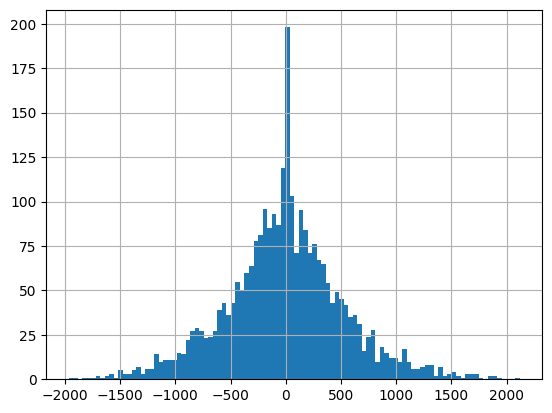

In [40]:
tmp['baseline'].diff().hist(bins=100)

# Case 6: Semi-dynamic baseline with X minute resolution, using the latest available power. Delayed by Y seconds to match activation time

In [41]:
mask = (df_power_10s.index < '2025-06-09 10:00:00') | (df_power_10s.index > '2025-06-09 11:00:00')    # remove mfrr testing period
df_c6 = df_power_10s.loc[mask,['active_power', 'available_power', 'dso_sold_power']].copy()
#tmp = df_c6[['available_power']].copy()
movmean_minutes = 1
#tmp = df_c6[['available_power']].rolling(window=movmean_minutes*60, min_periods=1).mean().copy() - 114
tmp = df_c6[['available_power']].copy() - 133
resolution_str = '112.5s'
tmp = tmp.resample(resolution_str).first()
tmp = tmp.resample('1s').ffill()
delay = 50
tmp = tmp.shift(delay)
df_c6['baseline'] = tmp['available_power']
df_c6['baseline_error'] = df_c6['baseline'] - df_c6['active_power']
df_c6['baseline_error_filtered'] = df_c6['baseline_error'].rolling(5*60).mean()  # 5min rolling mean
df_c6 = df_c6.dropna()
del tmp
df_c6

,active_power,available_power,dso_sold_power,baseline,baseline_error,baseline_error_filtered
2025-06-05 12:47:00+00:00,827.11,879.0,1023.0,1023.0,195.89,-74.621933
2025-06-05 12:47:10+00:00,803.10,866.0,1023.0,1023.0,219.90,-73.251000
2025-06-05 12:47:20+00:00,920.25,883.0,1023.0,1023.0,102.75,-72.724733
2025-06-05 12:47:30+00:00,1019.91,875.0,1023.0,1023.0,3.09,-72.672100
2025-06-05 12:47:40+00:00,1017.10,899.0,1023.0,1023.0,5.90,-72.691133
...,...,...,...,...,...,...
2025-06-30 21:44:20+00:00,280.70,329.0,233.2,214.0,-66.70,-86.852667
2025-06-30 21:44:30+00:00,285.34,326.0,233.2,214.0,-71.34,-86.800500
2025-06-30 21:44:40+00:00,285.68,326.0,233.2,214.0,-71.68,-86.737833
2025-06-30 21:44:50+00:00,284.16,324.0,233.2,214.0,-70.16,-86.657633


<Axes: title={'center': 'Case 6: Trolleberg active power vs baseline (112.5s resolution, last value, 50sec activation delay)'}>

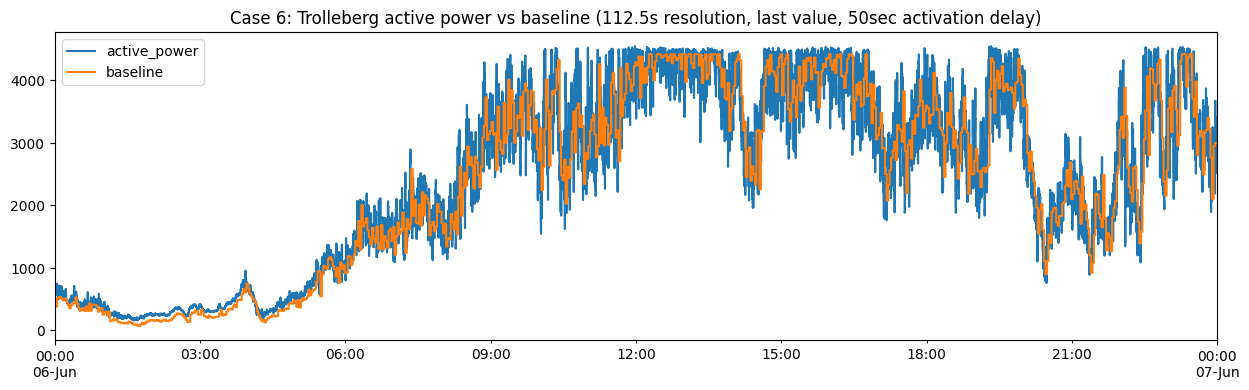

In [42]:
df_ = df_c6['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_[['active_power', 'baseline']].plot(figsize=(15,4), title=f'Case 6: Trolleberg active power vs baseline ({resolution_str} resolution, last value, {delay}sec activation delay)', drawstyle='steps-post')

In [43]:
print("-- All data:")
print_baseline_stats(df_c6, 'baseline_error')

threshold = 2000  # kW
df_ = df_c6[df_c6['dso_sold_power'] > threshold] # when we have predicted more than threshold kW
print(f"-- Data with DSO sold power > {threshold} kW:")
print_baseline_stats(df_, 'baseline_error')

print(f"-- With {threshold}kW threshold and 5 minute rolling mean applied:")
print_baseline_stats(df_, 'baseline_error_filtered')

-- All data:
|Mean error| = -20.70 kW     -> min mfrr power = -103.51 kW
|95th - 5th percentile error| / 2 = 713.94 kW   -> min mfrr power = 1427.88 kW
-- Data with DSO sold power > 2000 kW:
|Mean error| = 66.24 kW     -> min mfrr power = 331.20 kW
|95th - 5th percentile error| / 2 = 1046.61 kW   -> min mfrr power = 2093.22 kW
-- With 2000kW threshold and 5 minute rolling mean applied:
|Mean error| = 63.69 kW     -> min mfrr power = 318.47 kW
|95th - 5th percentile error| / 2 = 511.77 kW   -> min mfrr power = 1023.55 kW


In [44]:
threshold = 2000
print(f"Baseline error statistics for baseline above {threshold} kW")

# Calculate the mean change in setpoint.
tmp = df_c6[df_c6['baseline'] > threshold].copy()  # Only consider values above 2000 kW
tmp = tmp.resample('3.5min').first()

print(f"Absolute change in baseline:")
print("Percentile\tValue")

# ----

# 1st percentile of the change in setpoint
percentile_1_diff = tmp['baseline'].diff().abs().quantile(0.01)
print(f"1st\t\t{percentile_1_diff:.2f} kW")

# 5th percentile of the change in setpoint
percentile_5_diff = tmp['baseline'].diff().abs().quantile(0.05)
print(f"5th\t\t{percentile_5_diff:.2f} kW") 

# 10th percentile of the change in setpoint
percentile_10_diff = tmp['baseline'].diff().abs().quantile(0.10)
print(f"10th\t\t{percentile_10_diff:.2f} kW")

# 25th percentile of the change in setpoint
percentile_25_diff = tmp['baseline'].diff().abs().quantile(0.25)
print(f"25th\t\t{percentile_25_diff:.2f} kW")

# 35th percentile of the change in setpoint
percentile_35_diff = tmp['baseline'].diff().abs().quantile(0.35)
print(f"35th\t\t{percentile_35_diff:.2f} kW")

# -----

# 50th percentile of the change in setpoint
median_diff = tmp['baseline'].diff().abs().median()
print(f"Median\t\t{median_diff:.2f} kW")

# -----

# 65th percentile of the change in setpoint
percentile_65_diff = tmp['baseline'].diff().abs().quantile(0.65)
print(f"65th\t\t{percentile_65_diff:.2f} kW")

# 75th percentile of the change in setpoint
percentile_75_diff = tmp['baseline'].diff().abs().quantile(0.75)
print(f"75th\t\t{percentile_75_diff:.2f} kW")

# 90th percentile of the change in setpoint
percentile_90_diff = tmp['baseline'].diff().abs().quantile(0.90)
print(f"90th\t\t{percentile_90_diff:.2f} kW")

# 95th percentile of the change in setpoint
percentile_95_diff = tmp['baseline'].diff().abs().quantile(0.95)
print(f"95th\t\t{percentile_95_diff:.2f} kW")

# 99th percentile of the change in setpoint
percentile_99_diff = tmp['baseline'].diff().abs().quantile(0.99)
print(f"99th\t\t{percentile_99_diff:.2f} kW")

Baseline error statistics for baseline above 2000 kW
Absolute change in baseline:
Percentile	Value
1st		0.00 kW
5th		0.00 kW
10th		14.00 kW
25th		92.00 kW
35th		144.20 kW
Median		257.00 kW
65th		405.80 kW
75th		548.00 kW
90th		898.00 kW
95th		1119.40 kW
99th		1568.80 kW


## Trial 1: Try different filter times and baseline resolutions

In [45]:
mask = (df_power_10s.index < '2025-06-09 10:00:00') | (df_power_10s.index > '2025-06-09 11:00:00')    # remove mfrr testing period
df_t1 = df_power_10s.loc[mask,['active_power', 'available_power', 'dso_sold_power']].copy()
window = 15*60  # moving average window size in seconds
tmp = df_t1[['available_power']].rolling(window=window, min_periods=1).mean()
resolution_str = '5min'
tmp = df_t1.resample(resolution_str).first()
tmp = tmp.resample('1s').ffill()
df_t1['baseline'] = tmp['available_power']
df_t1['baseline_error'] = df_t1['baseline'] - df_t1['active_power']
df_t1['baseline_error_filtered'] = df_t1['baseline_error'].rolling(5*60).mean()  # 5min rolling mean
df_t1 = df_t1.dropna()
del tmp
df_t1

,active_power,available_power,dso_sold_power,baseline,baseline_error,baseline_error_filtered
2025-06-05 12:46:10+00:00,874.01,1044.0,1023.0,1156.0,281.99,99.051767
2025-06-05 12:46:20+00:00,744.59,1023.0,1023.0,1156.0,411.41,101.185700
2025-06-05 12:46:30+00:00,734.20,1005.0,1023.0,1156.0,421.80,103.654867
2025-06-05 12:46:40+00:00,768.67,930.0,1023.0,1156.0,387.33,106.423400
2025-06-05 12:46:50+00:00,804.88,887.0,1023.0,1156.0,351.12,108.845967
...,...,...,...,...,...,...
2025-06-30 21:44:20+00:00,280.70,329.0,233.2,372.0,91.30,50.460667
2025-06-30 21:44:30+00:00,285.34,326.0,233.2,372.0,86.66,50.719500
2025-06-30 21:44:40+00:00,285.68,326.0,233.2,372.0,86.32,50.988833
2025-06-30 21:44:50+00:00,284.16,324.0,233.2,372.0,87.84,51.275700


In [46]:
print("-- All data:")
print_baseline_stats(df_t1, 'baseline_error')

threshold = 1500  # kW
df_ = df_t1[df_t1['dso_sold_power'] > threshold] # when we have predicted more than threshold kW
print(f"-- Data with DSO sold power > {threshold} kW:")
print_baseline_stats(df_, 'baseline_error')

print(f"-- With {threshold}kW threshold and 5 minute rolling mean applied:")
print_baseline_stats(df_, 'baseline_error_filtered')

-- All data:
|Mean error| = 110.68 kW     -> min mfrr power = 553.39 kW
|95th - 5th percentile error| / 2 = 734.40 kW   -> min mfrr power = 1468.80 kW
-- Data with DSO sold power > 1500 kW:
|Mean error| = 183.34 kW     -> min mfrr power = 916.68 kW
|95th - 5th percentile error| / 2 = 1024.27 kW   -> min mfrr power = 2048.55 kW
-- With 1500kW threshold and 5 minute rolling mean applied:
|Mean error| = 180.94 kW     -> min mfrr power = 904.72 kW
|95th - 5th percentile error| / 2 = 501.48 kW   -> min mfrr power = 1002.96 kW


<Axes: title={'center': 'Trolleberg active power vs baseline (15.0min rolling mean of available power, 5min resolution)'}>

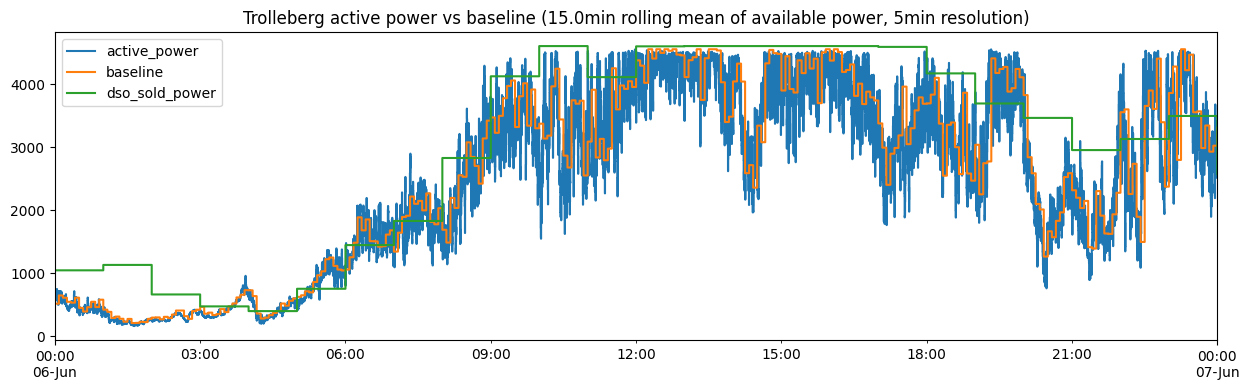

In [47]:
df_ = df_t1['2025-06-06 00:00:00':'2025-06-07 00:00:00']
df_[['active_power', 'baseline', 'dso_sold_power']].plot(figsize=(15,4), title=f'Trolleberg active power vs baseline ({window/60:.1f}min rolling mean of available power, {resolution_str} resolution)', drawstyle='steps-post')

# Accuracy of available power
